# Проект по проверки гипотиз для увеличение выручки

# Описание проекта

Я аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.


## Описание данных

Датасет `/datasets/hypothesis.csv.` включает в себя:

1. `Hypothesis` — краткое описание гипотезы;
2. `Reach` — охват пользователей по 10-балльной шкале;
3. `Impact` — влияние на пользователей по 10-балльной шкале;
4. `Confidence` — уверенность в гипотезе по 10-балльной шкале;
5. `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Датасет `/datasets/orders.csv`включает в себя:

1. `transactionId` — идентификатор заказа;
2. `visitorId` — идентификатор пользователя, совершившего заказ;
3. `date` — дата, когда был совершён заказ;
4. `revenue` — выручка заказа;
5. `group` — группа A/B-теста, в которую попал заказ.

Датасет `/datasets/visitors.csv` включает в себя:

1. `date` — дата;
2. `group` — группа A/B-теста;
3. `visitors` - количество пользователей в указанную дату в указанной группе A/B-теста

## Цели исследования

1. Построить воронку продаж, исследовал путь пользователей до покупки. 
2. Проанализироваь результаты A/B-теста введения новых шрифтов. 
3. Сравнить 2 контрольных группы между собой, убедиться в правильном разделении трафика, сравнить с тестовой группой
4. Дать ответ на вопрос, имеет ли значительное влияние на поведение пользователей новый шрифт.

**Часть 1. Приоритизация гипотез.**

Для начала загрузим необходимые библиотеки и настройки отображения выполненного кода

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import warnings 
sns.set(style="whitegrid")
sns.set_palette("Set2")
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

Изучим данный нам файлс гипотезами 

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


У нас есть 9 гипотез с разными характеристиками. Вспомним, что означает каждый из столбцов

**Стобец hypothesis** - сама  гипотеза.

**Параметр Reach** — это метрика, которая показывает количество людей (уникальных пользователей), которые увидели рекламное сообщение. В оффлайн-маркетинге чаще говорят о «людях», в онлайн-маркетинге обычно говорят о «пользователях». Синонимический ряд. Reach, охват, аудитория.

**Параметр Impact** показывает, насколько сильно изменение повлияет на охваченных пользователей.

**Параметр Confidence** показывает, насколько вы уверены в оценках других параметров. 

**Параметр Efforts** показывает, насколько сложно проверить гипотезу.

В первую очередь мы должны применить фреймворк ICE для приоритизации гипотез. 

**ICE** — один из самых популярных способов приоритизации задач:

ICE это акроним из следующих слов:
Impact – Какое влияние внедрение этой инициативы окажет на пользователя?
Confidence – Насколько мы уверены, что эта инициатива подтвердит нашу гипотезу и позволит добиться желаемого результата?
Efforts – Насколько легко ее внедрить? Какие потребуются затраты и ресурсы?

Рассчитывается по формуле 

*ICE CSORE = (Impact * Confidence) / Efforts*

Применим данный фреймворк, создав новый столбец в датасете и проведем сортировку от большего к меньшему


In [3]:
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis.sort_values('ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Согласно анализу, наиболее приоритетными будут следующие гипотезы:

1. Запустить акцию, дающую скидку на товар в день рождения

2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Проведем фреймворк RICE для приоритизации гипотез.

**Фреймворк RICE** состоит из четырёх компонентов:
    
*Reach* — скольких пользователей затронет изменение, которое вы хотите внести;

*Impact* — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;

*Confidence* — насколько вы уверены, что это изменение повлияет на пользователей именно так; 

*Efforts* — сколько стоит протестировать эту гипотезу. 

Рассчитывается по формуле

*RICE CSORE = (Reach * Impact * Confidence) / Efforts*

Применим данный фреймворк, добавив новый столбец в датасете и проведем сортировку от большего к меньшему


In [4]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis.sort_values('rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Согласно анализу, наиболее приоритетными будут следующие гипотезы:
    
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**Вывод:**

Как видно из двух проведенных анализов, мы видим, что приоритеты поменялись. Связанно это с тем, что второй фреймворк учитывает охват пользователей.

В тоже время мы наблюдаем, что в обоих случаях присутствует гипотеза "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

Как я считаю, хорошим решением будет начать работать с ней.

**Часть 2. Анализ A/B-теста**

Для начала изучим данные нам датасеты

In [5]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')    



In [6]:
display(orders)
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
display(visitors)
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


1. Отмечу остуствие пропусков в датасете.

2. Необходимо привезти название столбцов к стилистически верному виду.

3. Привести к нужному формату столбец с датами.

4. Проверить датасеты на дубликаты


In [8]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print('Количество дубликатов:',orders.duplicated().sum())

display(orders)
orders.info()

Количество дубликатов: 0


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print('Количество дубликатов:',visitors.duplicated().sum())

display(visitors)
visitors.info()

Количество дубликатов: 0


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Вывод:**

Мы выполнили поставленные задачи по подготовке данных.

После предпоготовки датасета можно приступать к анализу и построению графиков.


**Построение графиков**

Создадим таблицу, в которой будут аккумулированы данные: 
1. Количестве заказов; 
2. Kоличестве покупателей; 
3. Выручке и количестве посетителей, разделенных по дням и группам:


In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates().reset_index(drop=True)

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                           orders['group'] == x['group'])]
                           .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique',
                                 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                    .reset_index(drop=True))
                    
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                               visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                      .reset_index(drop=True))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData
cumulativeData['aov'] = cumulativeData["revenue"] / cumulativeData["orders"]
cumulativeData['conversion'] = cumulativeData["orders"] / cumulativeData["visitors"]

Построим график кумулятивной выручки по группам:

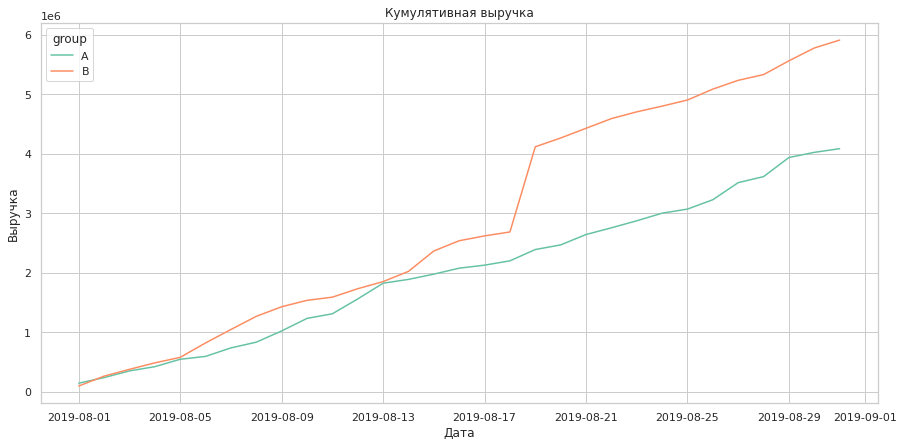

In [11]:
warnings.filterwarnings("ignore") 
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x="date", y="revenue", hue="group",
                  data=cumulativeData)
ax.set_title('Кумулятивная выручка')
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
plt.show()

В графике мы видим, что в обоих группах выручка со временем растет, однако в группе В мы видим резкий скачек с 18-19 чисел. Это может быть связано как с увеличением количества чеков(заказов), так и с их стоимостью (весом).

Построим график по среднему чеке в группах.

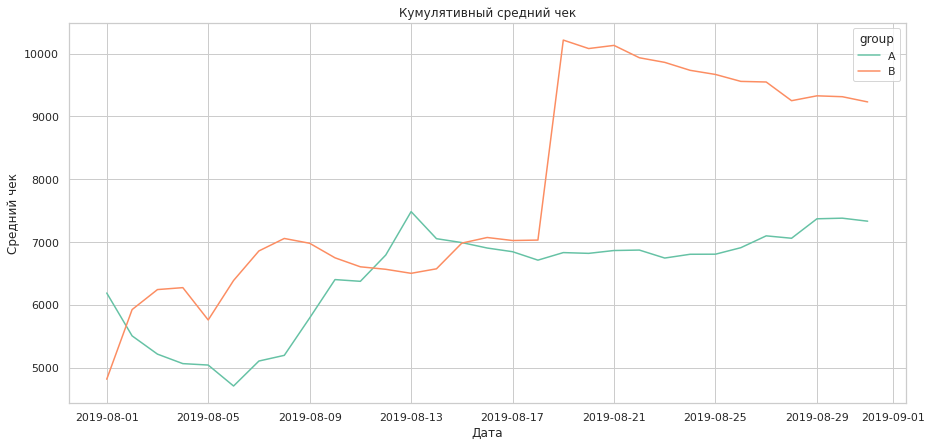

In [12]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x="date", y='aov',
                  hue="group", data=cumulativeData)
ax.set_title('Кумулятивный средний чек')
ax.set_xlabel('Дата')
ax.set_ylabel('Средний чек')
plt.show()

Вновь мы видим, что в группе В с 18-19 чисел идет всплеск, можно сделать предположение к предыдущему графику, что увеличилось не количество заказов, а их вес. 

С другой стороны, это может означать и единичные крупные чеки, что влияет на все исследование. Попробуем подробнее изучить средний чек и построим график относительного изменения кумулятивного среднего чека группы B к группе A.


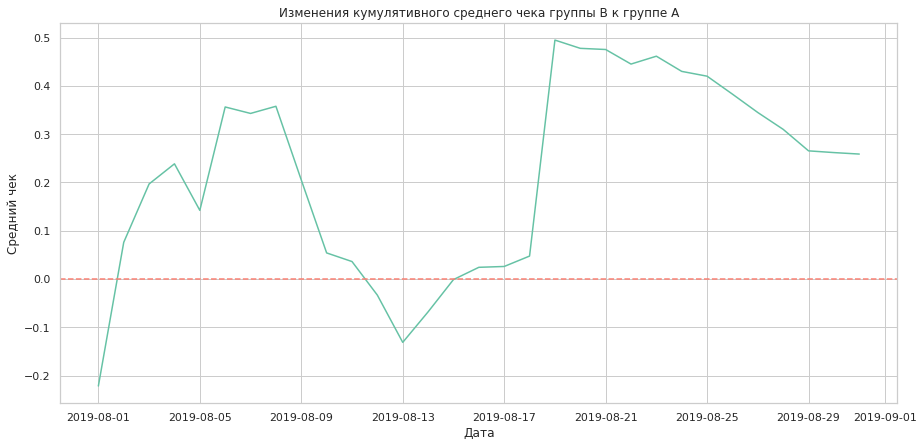

In [13]:
cumulativeDataA = cumulativeData.query('group == "A"').reset_index(drop=True)
cumulativeDataB = cumulativeData.query('group == "B"').reset_index(drop=True)
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x="date", y=((cumulativeDataB["aov"]/ cumulativeDataA["aov"]) - 1),data=cumulativeDataA) 
ax.set_title('Изменения кумулятивного среднего чека группы B к группе A')
ax.set_xlabel('Дата')
ax.set_ylabel('Средний чек')
ax.axhline(0, ls='--', color='salmon')
plt.show()

Действительно, в нескольких точках график различия между сегментами резко скачет. Это свидетельствует о крупных заказах и приводит к выбросам на графике.

Изучим вопрос чуть подробнее:


In [14]:
print('Медианное значение одного заказа 19 августа =',orders.query(' date == "2019-08-19" ')['revenue'].median())
orders.query(' date == "2019-08-19" ').sort_values(by='revenue', ascending=False).head(8)

Медианное значение одного заказа 19 августа = 2630.0


,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A
461,2683113224,154576532,2019-08-19,26550,B
525,3031564664,393266494,2019-08-19,21550,A
368,3268879337,2536252163,2019-08-19,20026,B
366,2037051350,1957949546,2019-08-19,16770,A


 Предположение подтвердилось - 19 августа был крупный (почти в 500 раз больше медианного значения) заказ № 425, его и можно считать выбросом. Продолжаем исследование 

Построим график кумулятивного среднего количества заказов на посетителя по группам.

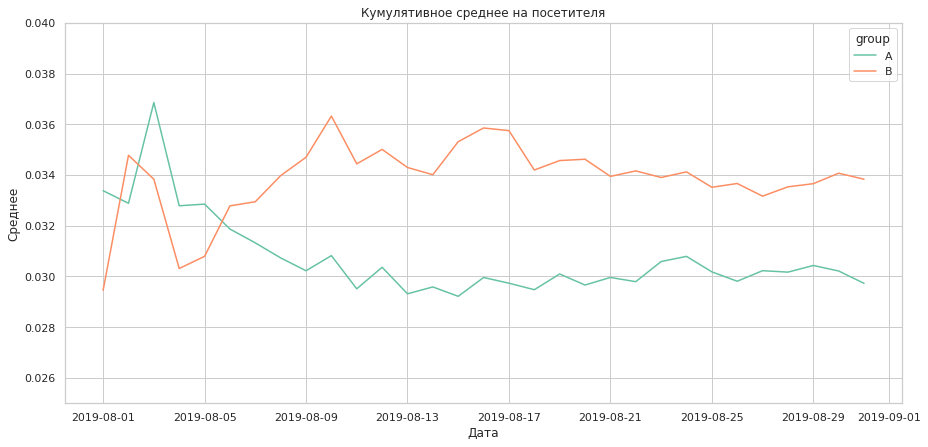

In [15]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x="date", y='conversion',
                  hue="group", data=cumulativeData)
ax.set_title('Кумулятивное среднее на посетителя')
ax.set_xlabel('Дата')
ax.set_ylabel('Среднее')
ax.set(ylim=(0.025, 0.04))
plt.show()

В начале исследование группы шли наравне, после 5 числа среднее на посетителя в группе В увеличилось, в А уменьшилось и далее они шли на фиксированном уровне.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A


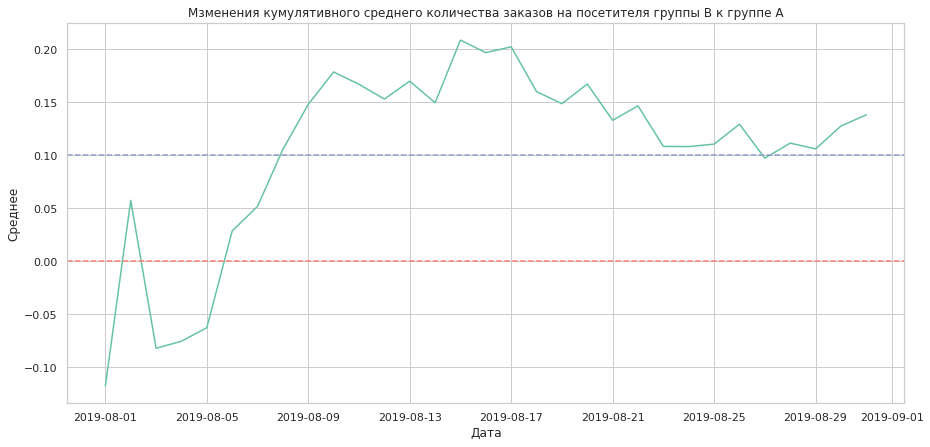

In [16]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x="date", y=((cumulativeDataB["conversion"]/ cumulativeDataA["conversion"]) - 1)
                  ,data=cumulativeDataA) 
ax.set_title('Мзменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
ax.set_xlabel('Дата')
ax.set_ylabel('Среднее')
ax.axhline(0, ls='--', color='salmon')
ax.axhline(0.1, ls='--', color='#8da0cb')
plt.show()

С начала месяца группа B лидирует по конверсии: прирост сначала колебался от 15% до 20% к концу месяца в районе 10-15%.

Построим точечный график количества заказов по пользователям.

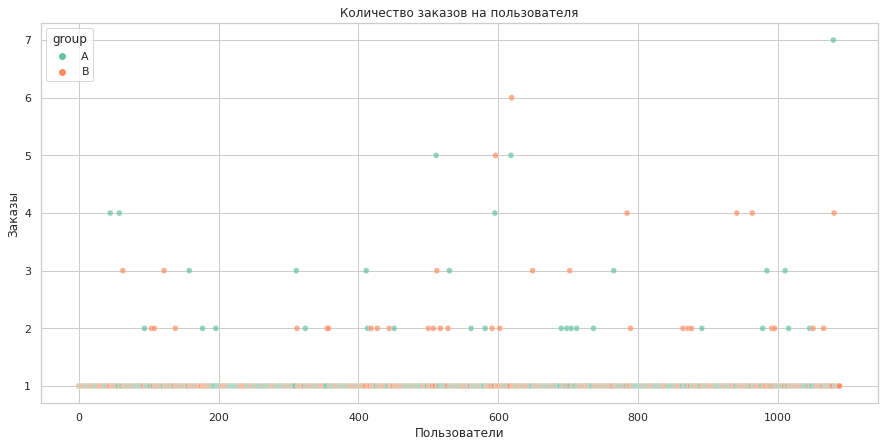

In [17]:
ordersByUsers = orders.groupby(['visitor_id', 'group'], as_index=False).agg({'transaction_id': 'nunique'})
ordersByUsers.columns = ['visitor_id','group','orders']
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15, 7))
ax = sns.scatterplot(x=x_values, y="orders", hue='group',hue_order=['A', 'B'],
                     data=ordersByUsers, alpha=.7)
ax.set_title('Количество заказов на пользователя')
ax.set_xlabel('Пользователи')
ax.set_ylabel('Заказы')
plt.show()

Большая часть пользователей совершает 1 заказ на платформе. 

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [18]:
print('Колличество заказов для 95% и 99% пользователей = {}.'
      .format(np.percentile(ordersByUsers['orders'], [95, 99])))

Колличество заказов для 95% и 99% пользователей = [2. 4.].


Можно сказать, 5% пользователей заказывали 2 раза что-либо, только 1% пользователей заказывали что-то более 4 раз. Пусть 4 будет границей аномальных пользователей.

Построим точечный график стоимостей заказов.


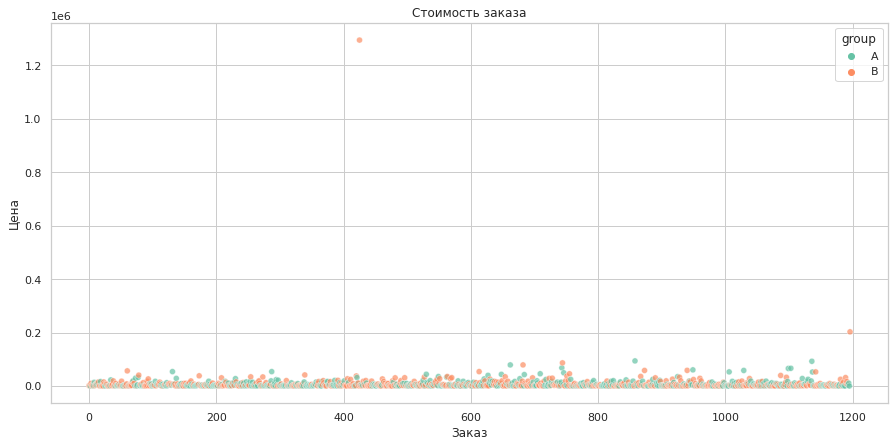

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15, 7))
ax = sns.scatterplot(x=x_values, y="revenue", hue='group',hue_order=['A', 'B'],
                     data=orders, alpha=.7)
ax.set_title('Стоимость заказа')
ax.set_xlabel('Заказ')
ax.set_ylabel('Цена')
plt.show()



Построим еще один график, где ограничим ось Y до 100 000

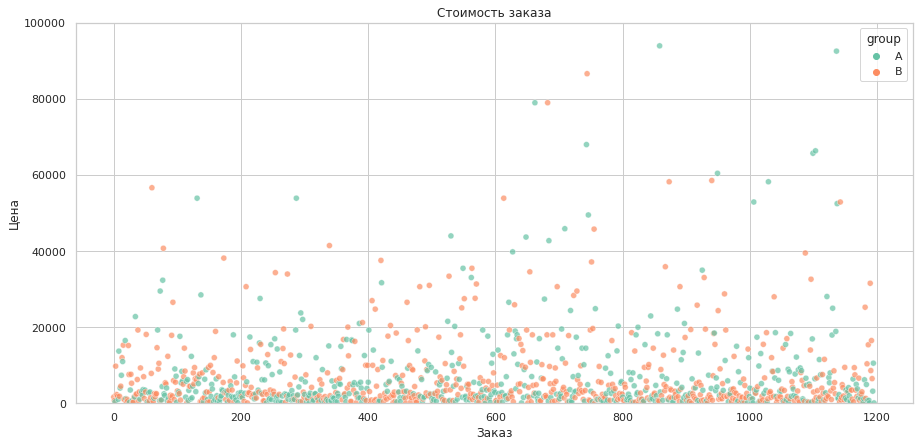

In [20]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 7))
ax = sns.scatterplot(
    x=x_values, y="revenue", hue='group', hue_order=['A', 'B'],
    data=orders, alpha=.7
)
ax.set_title('Стоимость заказа')
ax.set_xlabel('Заказ')
ax.set_ylabel('Цена')

# Set x-axis limits
ax.set_ylim(0, 100000)  # Adjust the values as per your desired range

plt.show()

Большая часть заказов не превышает 20000 рублей, что подтверждает вывод выше. Почти все заказы не превышают 60000 рублей. Так же мы видим те самые аномальные заказы в группе В, которые мы наблюдали ранее.

Посчитаем 95-й и 99-й перцентили стоимости заказов.


In [21]:
print('Стоимость заказов для 95% и 99% пользователей = {}'
      .format(np.percentile(orders['revenue'], [95, 99])))

Стоимость заказов для 95% и 99% пользователей = [28000.  58233.2]


5% заказов дороже 28 000 рублей.
1% заказов дороже 58 234 рублей.

Считаю, что 58 234 рублей является границей для аномальных заказов

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным - без удаление аномалий.

Для начала сформулируем гипотезы:
*H₀* - различий в конверсии между группами нет,
*H₁* - различия в конверсии между группами есть.   

Для расчета статистической значимости различий в конверсии между группами нам необходимо подготовить имеющиеся данные

In [22]:
# расчет количества пользователей в выбранную дату в группе А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# расчет количества пользователей до выбранной даты включительно в группе А
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

# расчет количества пользователей в выбранную дату в группе В
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

# расчет количества пользователей до выбранной даты включительно в группе В
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

# расчет количества заказов и суммарной выручки в выбранную дату в группе A
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# расчет суммарного числа заказов до выбранной даты включительно в группе A
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

# расчет количества заказов и суммарной выручки в выбранную дату в группе В
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# расчет суммарного числа заказов до выбранной даты включительно в группе В
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

# объединение датафреймов в один общий
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим переменные orders_by_users_a и orders_by_users_b со столбцами ['visitor_id', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

Объявим переменные sample_a и sample_b, в которых пользователям с заказами будет соответствовать число заказов пользователя, а пользователям без заказов — нули.

Посчитаем статистическую значимость различия конверсии по результатам месяца теста.

Применим тест Манна-Уитни.

Выведем p-value для сравнения конверсии между группами.

Вычислим относительное различие в конверсии между группами.

In [29]:
# формирование датафреймов в которых указано число совершённых заказов
# для пользователей, которые заказывали хотя бы 1 раз
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

# формирование переменных в которых пользователям с заказами
# будет соответствовать число заказов пользователя,
# а пользователям без заказов — нули
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(0, index=np.arange(
                          data['visitors_per_date_a'].sum() -
                          len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(
                          data['visitors_per_date_b'].sum() -
                          len(orders_by_users_b['orders'])), name='orders')], axis=0)

# рассчет статистической значимости различия конверсии по результатам теста Манна-Уитни
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

# рассчет относительного различия в конверсии между группами
print('Относительное различие в средней конверсии между группами по «сырым» данным:',
      '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

p-value = 0.017
Относительное различие в средней конверсии между группами по «сырым» данным: 0.138


Так как p-value = 0.017, что меньше 0.05, то мы отвергаем H₀ - "различий в конверсии между группами нет". Она есть, в группе В средняя конверсия больше чем в А. Она составляет 13,8%

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформируем гипотезы *H₀* - различий в среднем чеке между группами нет; *H₁* - различия в среднем чеке между группами есть.

In [32]:
alpha = 0.05  # Задаем уровень значимости

results = stats.mannwhitneyu(ordersA['revenue'], ordersB['revenue'])
print('p-значение: {:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: "Cтатистически значимые различия в среднем чеке между группами отсутствуют".')
else:
    print('Не получилось отвергнуть нулевую гипотезу: "Cтатистически значимые различия в среднем чеке между группами отсутствуют".')

print("Относительный прирост в среднем чеке группы B: {0:.3f}"
      .format(ordersB['revenue'].mean() / ordersA['revenue'].mean() - 1))


p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу: "Cтатистически значимые различия в среднем чеке между группами отсутствуют".
Относительный прирост в среднем чеке группы B: 0.259


P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Однако мы вдим, чтоприрост составляе 26%,на это могут влиять ранее замеченные аномальные заказы.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным - без аномальных значений.

Ранее мы выяснили, что 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 рублям, а перцентили количества заказов на одного пользователя равны 2 и 4 заказам на пользователя.

Возьмем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000 рублей и запишем это в переменных many_orders и expensive_orders. Тем самым мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

In [33]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .sort_values(by='transaction_id', ascending=False)
    .rename(columns={'transaction_id': 'orders'})
)


many_orders = np.percentile(orders_by_users['orders'], 95)
expensive_orders = np.percentile(orders['revenue'], 95)
users_with_many_orders = pd.concat([
    orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
    orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id']], axis=0)
users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']
abnormal_users = (pd.concat([
    users_with_many_orders,
    users_with_expensive_orders], axis=0)
                  .drop_duplicates()
                  .sort_values())

print(abnormal_users.head())
print('\n')
print('Количество аномальных пользователей:', abnormal_users.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64


Количество аномальных пользователей: 74


Мы выявили, что аномальных пользователей 74.  Необходимо повторно провести анализ по "чистым" данным. 

Сформируем гипотезы - *H₀* - различий в конверсии между группами нет,
*H₁* - различия в конверсии между группами есть. 

In [34]:
sample_a_filtered = pd.concat([
    orders_by_users_a[np.logical_not(
        orders_by_users_a['visitor_id']
        .isin(abnormal_users))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() -
                                 len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b_filtered = pd.concat([
    orders_by_users_b[np.logical_not(
        orders_by_users_b['visitor_id']
        .isin(abnormal_users))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() -
                                 len(orders_by_users_b['orders'])), name='orders')], axis=0)

# рассчет статистической значимости различия конверсии по результатам теста Манна-Уитни
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))

# рассчет относительного различия в конверсии между группами
print('Относительное различие в средней конверсии между группами по «очищенным» данным:',
      '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value = 0.013
Относительное различие в средней конверсии между группами по «очищенным» данным: 0.173


Вывод: p-value = 0.013, что меньше 0.05 - нулевую гипотезу вновь можно опровергнуть. Разница между конверсиями в "сырых" и "чистых" данных незначительна 13,8% и 17,3%, средняя конверсия в группе В выше.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы *H₀* - различий в среднем чеке между группами нет; *H₁* - различия в среднем чеке между группами есть.

In [35]:
print('p-value =',
      '{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id']
                       .isin(abnormal_users)))]['revenue'], 
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id']
                       .isin(abnormal_users)))]['revenue'])[1]))

print('Относительное различие в среднем чеке между группами по «очищенным» данным:',
      '{0:.3f}'.format(
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id']
                       .isin(abnormal_users)))]['revenue'].mean() /
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id']
                       .isin(abnormal_users)))]['revenue'].mean() - 1))

p-value = 0.738
Относительное различие в среднем чеке между группами по «очищенным» данным: -0.020


Вывод: p-value = 0.738, что значительно больше 0.05. Это подтверждает нулевую гипотезу - различий в среднем чеке между группами нет. В тоже время изменился сам средний чек - после очистки от аномальных пользователей мы видим, что в группе В средний чек упал, в то время как в сырых данных он был выше. Опять же, вспоминая что в группе В был как минимум 1 заказ, который был больше медианного почти в 500 раз, мы получили куда более актуальные результаты

Проведя анализ A/B-тестирования мы пришли к следующим выводам:
    
Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
По сырым данным и по очищенным нет статистически значимого различия по среднему чеку между группами.
График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.
График различия среднего чека колеблется, хотя к концу периода наблюдения тоже показывает, что результаты группы B становятся лучше группы A. Но глядя на данные, очищенные от аномальных пользователей, мы видим, что средний чек практически не изменился и даже стал немного меньше по отношению к группе A.    

Считаю, что в исследованиях побеждает группа В ввиду отличной конверсии при незначительном снижении среднего чека, опять же- именно в данной группе
